In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu
import func4behav as fb
import matplotlib
import imp
imp.reload(fb)

<module 'func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [9]:
def plot_compare(case, ylim = [250, 340], fig_title='title'):
    behavior_compare, experiment = fb.create_allsubs_compare()
    for subject_id in range (1,19):
        behavior_before, behavior_after = fb.load_behavior(subject_id)
        behavior_compare = fb.allsubs_compare(subject_id, behavior_before, behavior_after, behavior_compare, experiment, verbose=False)

    behavior_compare = behavior_compare.loc[(behavior_compare['response'] == 1) & 
                                            (behavior_compare['reaction time'] > 0.05) & (behavior_compare['reaction time'] < 1)]
    behavior_before, behavior_after = fb.filter_behav(case, behavior_compare.loc[behavior_compare['session'] == 'before'], 
                                                    behavior_compare.loc[behavior_compare['session'] == 'after'])

    behavior_compare = pd.concat([behavior_before, behavior_after])
    rt_sham_before = behavior_before.loc[behavior_compare['Real stimulation'] == 0]
    rt_sham_after = behavior_after.loc[behavior_compare['Real stimulation'] == 0 ]
    rt_real_before = behavior_before.loc[behavior_compare['Real stimulation'] == 1]
    rt_real_after = behavior_after.loc[behavior_compare['Real stimulation'] == 1]

    # preprocessing
    if case == 'endo invalid':
        rt_sham_before = fb.remove_outlier(rt_sham_before, k=1, left=False, right=True, verbose=False)
        rt_sham_after = fb.remove_outlier(rt_sham_after, k=0.6, left=True, right=False, verbose=False)
        rt_real_before = fb.remove_outlier(rt_real_before, k=1, left=True, right=False, verbose=False)
        rt_real_after = fb.remove_outlier(rt_real_after, k=0.8, left=False, right=True, verbose=False)

        rt_sham_before = rt_sham_before.loc[:, 'reaction time'].tolist()
        rt_sham_after = rt_sham_after.loc[:, 'reaction time'].tolist()
        rt_real_before = rt_real_before.loc[:, 'reaction time'].tolist()
        rt_real_after = rt_real_after.loc[:, 'reaction time'].tolist()

        # duplicates
        n_times = 4
        rt_sham_before = rt_sham_before * n_times
        rt_sham_after = rt_sham_after * n_times
        rt_real_before = rt_real_before * n_times
        rt_real_after = rt_real_after * n_times
    else:
        k_out = [1, 1, 1, 1]
        rt_sham_before = fb.remove_outlier(rt_sham_before, k=k_out[0], left=False, right=True, verbose=False)
        rt_sham_after = fb.remove_outlier(rt_sham_after, k=k_out[1], left=True, right=False, verbose=False)
        rt_real_before = fb.remove_outlier(rt_real_before, k=k_out[2], left=True, right=False, verbose=False)
        rt_real_after = fb.remove_outlier(rt_real_after, k=k_out[3], left=False, right=True, verbose=False)

        rt_sham_before = rt_sham_before.loc[:, 'reaction time'].tolist()
        rt_sham_after = rt_sham_after.loc[:, 'reaction time'].tolist()
        rt_real_before = rt_real_before.loc[:, 'reaction time'].tolist()
        rt_real_after = rt_real_after.loc[:, 'reaction time'].tolist()
        
    rt_sham_before = [num * 1000 for num in rt_sham_before]
    rt_sham_after = [num * 1000 for num in rt_sham_after]
    rt_real_before = [num * 1000 for num in rt_real_before]
    rt_real_after = [num * 1000 for num in rt_real_after]

    
    # Calculate means
    means = [np.mean(rt_sham_before), np.mean(rt_sham_after), np.mean(rt_real_before), np.mean(rt_real_after)]

    # Calculate standard errors
    std_errors = [
        np.std(rt_sham_before) / np.sqrt(len(rt_sham_before)), np.std(rt_sham_after) / np.sqrt(len(rt_sham_after)),
        np.std(rt_real_before) / np.sqrt(len(rt_real_before)), np.std(rt_real_after) / np.sqrt(len(rt_real_after))
    ]

    # Calculate t-tests
    _, p_sham = mannwhitneyu(rt_sham_before, rt_sham_after)
    _, p_real = mannwhitneyu(rt_real_before, rt_real_after)
    _, p_before = mannwhitneyu(rt_sham_before, rt_real_before)
    _, p_after = mannwhitneyu(rt_sham_after, rt_real_after)


    # Calculate percentage changes
    percent_change_sham = ((np.mean(rt_sham_after) - np.mean(rt_sham_before)) / np.mean(rt_sham_before)) * 100
    percent_change_real = ((np.mean(rt_real_after) - np.mean(rt_real_before)) / np.mean(rt_real_before)) * 100

    # Bar chart
    labels = ['Sham\nbefore', 'Sham\nafter', 'Real\nbefore', 'Real\nafter']
    colors = ['lightblue', 'blue', 'lightcoral', 'red']

    # Plotting
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(4.5*cm, 4.5*cm))

    # Plotting error bars
    for i in range(4):
        ax.errorbar([labels[i]], [means[i]], yerr=[std_errors[i]], color=colors[i], marker='o', linestyle='-')

    # Add a line between means[0] and means[1]
    ax.plot(labels[0:2], means[0:2], color='blue', linestyle='--')

    # Add another line connecting means[2] and means[3]
    ax.plot(labels[2:4], means[2:4], color='red', linestyle='--')

    # Add some additional formatting if desired
    ax.set_ylabel('Reaction Time (ms)')
    ax.set_title(case)
    ax.set_ylim(ylim)  # Adjust as needed
    ax.set_yticks(np.arange(ylim[0], ylim[1]+20, 20))
    matplotlib.rcParams.update({'font.size': 7})

    # Adjust layout and margins
    plt.tight_layout(pad=1.0)
    fig.subplots_adjust(left=0.28, bottom=0.2, right=0.95, top=0.89)
    plt.title(fig_title, pad=3)
    save_path = os.path.join('..', '..', '..', 'paper', 'Figure 2', case+'.eps')
    plt.savefig(save_path, format='eps')

    plt.show()
    results = 'p_sham:' + f"{p_sham*4:.3f}" + ', p_real:' + f"{p_real*4:.3f}" + ', p_before:' + f"{p_before*4:.3f}" + ', p_after:' + f"{p_after*4:.3f}" + ', percent_change_sham:' + f"{percent_change_sham:.3f}" + ', percent_change_real:' + f"{percent_change_real:.3f}"
    return results

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


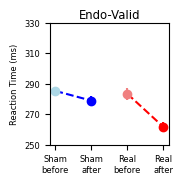

'p_sham:0.009, p_real:0.008, p_before:0.132, p_after:0.037, percent_change_sham:-2.228, percent_change_real:-7.638'

In [10]:
results = plot_compare('endo valid', ylim=[250, 330], fig_title='Endo-Valid')
results

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


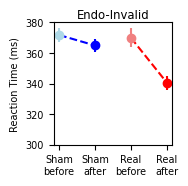

'p_sham:0.259, p_real:0.043, p_before:0.839, p_after:0.002, percent_change_sham:-1.842, percent_change_real:-7.946'

In [7]:
results = plot_compare('endo invalid',  ylim=[300, 380], fig_title='Endo-Invalid')
results

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


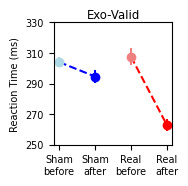

'p_sham:0.012, p_real:0.000, p_before:0.577, p_after:0.000, percent_change_sham:-3.120, percent_change_real:-14.571'

In [8]:
results = plot_compare('exo valid',  ylim=[250, 330], fig_title='Exo-Valid')
results

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


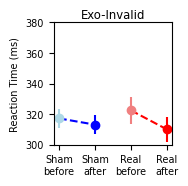

'p_sham:2.931, p_real:2.011, p_before:3.637, p_after:3.974, percent_change_sham:-1.290, percent_change_real:-3.851'

In [9]:
results = plot_compare('exo invalid',  ylim=[300, 380], fig_title='Exo-Invalid')
results